In [1]:
#import necessary libraries

import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler, LabelEncoder
from itertools import cycle, islice

import networkx as nx
from scipy import sparse
from sklearn.cluster import KMeans

np.random.seed(0)

### Spectral Clustering

"Three algorithms for Spectral Clustering have been implemented
- Unnormalized Spectral Clustering
- Normalized Spectral Clustering according to Shi and Malik (2000) - Uses the Laplacian matrix based on Random Walk (𝐿𝑟𝑤)
- Normalized Spectral Clustering according to Ng, Jordan, and Weiss (2002) - Uses the symmetric Laplacian matrix (𝐿𝑠𝑦𝑚)

A function has been created for each of the algorithms. Each function takes as input the dataset 𝑋 (which should already be properly normalized), the number of clusters 𝑘, and the parameter 𝑝𝑎𝑟𝑎𝑚𝑠, which should contain information defining how the similarity graph used by the algorithm will be generated.

In [2]:
# Function to obtain the cluster centroids from the X data and spectral_labels markings

def getClusterCentroids(X,spectral_labels):    
    tmp = pd.DataFrame(X)
    cols = tmp.columns
    tmp['spectral_labels'] = spectral_labels
    return tmp.groupby("spectral_labels")[cols].mean().values


def unnormalizedSpectralClustering(X,k,params):

    n = len(X)

    ## Construct a similarity graph. Let W be its weighted adjacency matrix
    # Computes the (weighted) graph of k-Neighbors for points in X. The distance metric used is 'euclidean'
    A = kneighbors_graph(X, params['k_neighbors'], mode='distance', metric='euclidean', include_self=True)
    
    ## Compute the unnormalized Laplacian L
    G = nx.from_scipy_sparse_matrix(A)
    L = nx.laplacian_matrix(G)
    
    ## Compute the first k eigenvectors u_1,...,u_k of L
    eigenvalues, eigenvectors = sparse.linalg.eigs(L, k=k, which='SM')
    eigenvectors = np.real_if_close(eigenvectors)
    eigenvalues = np.real_if_close(eigenvalues)
    kfirst_indices = np.argsort(eigenvalues)[:k]
    
    ## Let U be the matrix containing the vectors u_1,...,u_k as columns
    ## For i=1,...,n, let y_i be the vector corresponding to the i-th row of U
    Y = eigenvectors[:,kfirst_indices]
    
    ## Cluster the points (y_i)i=1,...,n with the k-means algorithm into clusters C_1,...,C_k
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Y)
    
    ## Output: Clusters A_1,...,A_k with A_i = {j|y_j in C_i}
    return {
        'labels': kmeans.labels_,
        'centroids': getClusterCentroids(X,kmeans.labels_)
    }

def normalizedRWSpectralClustering(X,k,params): 
    ## Construct a similarity graph. Let W be its weighted adjacency matrix
    # Computes the (weighted) graph of k-Neighbors for points in X. The default distance is 'euclidean'
    A = kneighbors_graph(X, params['k_neighbors'], mode='distance', metric='euclidean', include_self=True)

    ## Compute the unnormalized Laplacian L
    G = nx.from_scipy_sparse_matrix(A)
    L = nx.laplacian_matrix(G)
    
    degreeView = G.degree(G.nodes(), weight='weight')
    degrees = np.array(degreeView)[:,1]
    D = sparse.diags(degrees)
    
    ## Compute the first k generalized eigenvectors u_1,...,u_k of the generalized eigenproblem Lu=lambda*Du
    eigenvalues, eigenvectors = sparse.linalg.eigs(L, k=k, M=D, which='SM') # SM = Smallest Magnitude
    eigenvectors = np.real_if_close(eigenvectors)
    eigenvalues = np.real_if_close(eigenvalues)
    kfirst_indices = np.argsort(eigenvalues)[:k]
    
    ## Let U be the matrix containing the vectors u_1,...,u_k as columns
    U = eigenvectors[:,kfirst_indices]

    ## For i=1,...,n, let y_i be the vector corresponding to the i-th row of U
    Y = U

    ## Cluster the points (y_i)i=1,...,n with the k-means algorithm into clusters C_1,...,C_k
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Y)

    ## Output: Clusters A_1,...,A_k with A_i = {j|y_j in C_i}    
    return {
        'labels': kmeans.labels_,
        'centroids': getClusterCentroids(X,kmeans.labels_)
    }


def normalizedSymSpectralClustering(X,k,params):
    n = len(X)
    
    ## Construct a similarity graph by one of the ways described in Section 2. Let W be its weighted adjacency matrix
    # Computes the (weighted) graph of k-Neighbors for points in X. The default distance is 'euclidean'
    A = kneighbors_graph(X, params['k_neighbors'], mode='distance', metric='euclidean', include_self=True)
    
    ## Compute the normalized Laplacian L_sym
    G = nx.from_scipy_sparse_matrix(A)
    L_sym = nx.normalized_laplacian_matrix(G)
    
    ## Compute the first k eigenvectors u_1,...,u_k of L_sym
    eigenvalues, eigenvectors = sparse.linalg.eigs(L_sym, k=k, which='SM')
    eigenvectors = np.real_if_close(eigenvectors)
    eigenvalues = np.real_if_close(eigenvalues)
    kfirst_indices = np.argsort(eigenvalues)[:k]
    
    ## Let U be the matrix containing the vectors u_1,...,u_k as columns
    U = eigenvectors[:,kfirst_indices]
    
    ## Form the matrix T from U by normalizing the rows to norm 1
    T = U / np.sqrt(np.sum(U**2, axis=1))[:,np.newaxis]
    
    ## For i=1,...,n, let y_i be the vector corresponding to the i-th row of T
    ## Cluster the points (y_i)i=1,...,n with the k-means algorithm into clusters C_1,...,C_k
    kmeans = KMeans(n_clusters=k, random_state=0).fit(T)
    
    ## Output: Clusters A_1,...,A_k with A_i = {j|y_j in C_i} 
    return {
        'labels': kmeans.labels_,
        'centroids': getClusterCentroids(X,kmeans.labels_)
    }

### Preliminary tests

As a first test, I will use Spectral Clustering on 6 very simple datasets and compare it with the more well-known KMeans method.


In [3]:
# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)


In [4]:
simple_datasets = [
    (noisy_circles, {'name': 'Noisy Circles','n_clusters': 2}),
    (noisy_moons, {'name': 'Noisy Moons', 'n_clusters': 2}),
    (varied, {'name': 'Blobs with varied variances','n_clusters': 3}),
    (aniso, {'name': 'Anisotropic data', 'n_clusters': 3}),
    (blobs, {'name': 'Blobs', 'n_clusters': 3}),
    (no_structure, {'name': 'No structure', 'n_clusters': 3})]

C:\Users\akash\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\akash\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\akash\AppData\Local\Temp\ipykernel_29936\3103856593.py:19: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(A)
<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
C:\Users\akash\anaconda3\Lib\site-packages\sklearn\cluster\_kmea

C:\Users\akash\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\akash\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\akash\AppData\Local\Temp\ipykernel_29936\3103856593.py:84: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(A)
<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
C:\Users\akash\anaconda3\Lib\site-packages\sklearn\c

C:\Users\akash\AppData\Local\Temp\ipykernel_29936\3103856593.py:19: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(A)
<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
C:\Users\akash\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\akash\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\akash\AppData\Local\Temp\ipykernel_29936\3103856593.py:

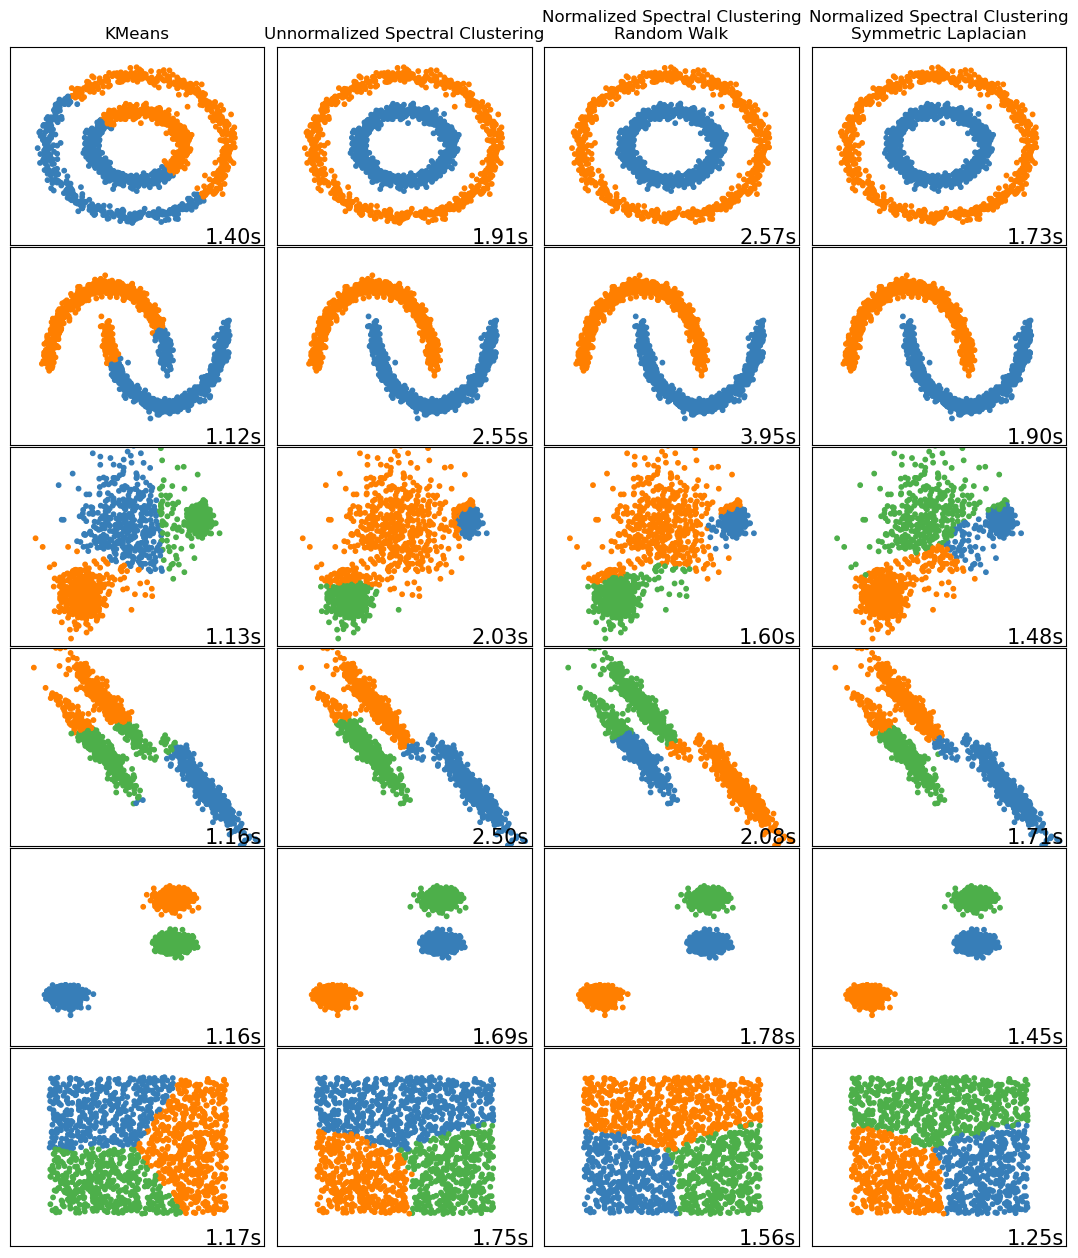

In [5]:
# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(4 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

for i_dataset, (dataset, params) in enumerate(simple_datasets):
    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    kmeans = cluster.KMeans(n_clusters=params['n_clusters'])
    
    clustering_algorithms = (
        ('KMeans', kmeans),
        ('Unnormalized Spectral Clustering', unnormalizedSpectralClustering),
        ('Normalized Spectral Clustering\nRandom Walk', normalizedRWSpectralClustering),
        ('Normalized Spectral Clustering\nSymmetric Laplacian', normalizedSymSpectralClustering)
    )
    
    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        if name == 'KMeans':
            algorithm.fit(X)
        else:
            k = params['n_clusters']
            spectral_params = {
                'k_neighbors': 12
            }
            result = algorithm(X,k,spectral_params)
            
        t1 = time.time()
        
        if name == 'KMeans':
            y_pred = algorithm.labels_.astype(np.int64)
        else:
            y_pred = result['labels']
        
        plt.subplot(len(simple_datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))

        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

# Experimental Analysis

In the following analysis, the 3 Spectral Clustering algorithms will be tested on the UCI Image Segmentation dataset
  
The dataset contains features created from the RGB values of outdoor image segments. The features are numerical values, such as average saturation and average intensity. Each segment is classified as belonging to one of 7 classes. The classes are: BRICKFACE, FOLIAGE, GRASS, CEMENT, PATH, SKY, and WINDOW.

pre-processes the data so that the values of each field are on the same scale, using StandardScaler. Additionally, I apply the LabelEncoder to the classes and create a vector y with the actual classes.

In [6]:
ds = pd.read_csv("./datasets/segmentation.test.txt")

X = ds.values
X = StandardScaler().fit_transform(X)
n = len(X)

y = LabelEncoder().fit_transform(ds.index)

we have 300 observations for each class. In other words, the classes are balanced.

In [7]:
ds.index.value_counts()

GRASS        300
PATH         300
WINDOW       300
CEMENT       300
FOLIAGE      300
SKY          300
BRICKFACE    300
dtype: int64

Below, we have an overview of all the features of the dataset.

In [8]:
ds.head()

,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN
GRASS,110.0,189.0,9,0.0,0.0,1.000000,0.666667,1.222222,1.186342,12.925926,10.888889,9.222222,18.666668,-6.111111,-11.111111,17.222221,18.666668,0.508139,1.910864
GRASS,86.0,187.0,9,0.0,0.0,1.111111,0.720082,1.444444,0.750309,13.740741,11.666667,10.333334,19.222221,-6.222222,-10.222222,16.444445,19.222221,0.463329,1.941465
GRASS,225.0,244.0,9,0.0,0.0,3.388889,2.195113,3.000000,1.520234,12.259259,10.333334,9.333334,17.111110,-5.777778,-8.777778,14.555555,17.111110,0.480149,1.987902
GRASS,47.0,232.0,9,0.0,0.0,1.277778,1.254621,1.000000,0.894427,12.703704,11.000000,9.000000,18.111110,-5.111111,-11.111111,16.222221,18.111110,0.500966,1.875362
GRASS,97.0,186.0,9,0.0,0.0,1.166667,0.691215,1.166667,1.005540,15.592592,13.888889,11.777778,21.111110,-5.111111,-11.444445,16.555555,21.111110,0.442661,1.863654


In [9]:
n_clusters = len(np.unique(y))
print("Number of clusters:",str(n_clusters))

Number of clusters: 7


Let's now run KMeans and the Spectral Clustering algorithms and compare their results.

To evaluate the performance of the clustering, we will compare the results with the real classes of the dataset. Since we have access to the real classes, we can use external clustering evaluation metrics.

The metric chosen for this work was the V-measure, which is an external metric based on entropy, introduced by Andrew Rosenberg and Julia Hirschberg in the paper "V-Measure: A conditional entropy-based external cluster evaluation measure". The V-measure is the harmonic mean between the homogeneity and completeness metrics, which are two desirable characteristics of a clustering, according to Andrew Rosenberg.

For the following analysis, the value of k=150 was defined to construct the k-nearest neighbors graph.

In [10]:
# KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
y_kmeans = kmeans.labels_
centroids = kmeans.cluster_centers_

# Spectral Clustering
params = {
    'k_neighbors': 150
}
# Unnormalized 
unnorm = unnormalizedSpectralClustering(X,n_clusters,params)
y_unnorm = unnorm['labels']
# Normalized - Random Walk Laplacian
norm_rw = normalizedRWSpectralClustering(X,n_clusters,params)
y_rw = norm_rw['labels']
# Normalized - Symmetric Laplacian
norm_sym = normalizedSymSpectralClustering(X,n_clusters,params)
y_sym = norm_sym['labels']

C:\Users\akash\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\akash\AppData\Local\Temp\ipykernel_29936\3103856593.py:19: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(A)
<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
C:\Users\akash\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\akash\AppData\Local\Temp\ipykernel_29936\3103856593.py:47: DeprecationWarning: 

The scipy.sparse array con

As we can see below, for this choice of k and using the V-measure metric, we obtained better clustering performance using spectral clustering, compared to KMeans.
KMeans resulted in a V-measure of 0.59, while the spectral clustering algorithms presented V-measures above 0.63.

In [11]:
from sklearn.metrics.cluster import normalized_mutual_info_score, v_measure_score
print("KMeans")
print("V-measure: {}".format(v_measure_score(y, y_kmeans).round(4)))
print("-------------------")
print("Spectral Clustering")
print("Unnormalized")
print("V-measure: {}".format(v_measure_score(y, y_unnorm).round(4)))
print()
print("Normalized - Random Walk Laplacian")
print("V-measure: {}".format(v_measure_score(y, y_rw).round(4)))
print()
print("Normalized - Symmetric Laplacian")
print("V-measure: {}".format(v_measure_score(y, y_sym).round(4)))

KMeans
V-measure: 0.5947
-------------------
Spectral Clustering
Unnormalized
V-measure: 0.6397

Normalized - Random Walk Laplacian
V-measure: 0.6333

Normalized - Symmetric Laplacian
V-measure: 0.6338


# k-NN sensitivity analysis

C:\Users\akash\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\akash\AppData\Local\Temp\ipykernel_29936\3103856593.py:19: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(A)
<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
C:\Users\akash\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\akash\AppData\Local\Temp\ipykernel_29936\3103856593.py:47: DeprecationWarning: 

The scipy.sparse array con

<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
C:\Users\akash\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\akash\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\akash\AppData\Local\Temp\ipykernel_29936\3103856593.py:19: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(A)
<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return 

C:\Users\akash\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\akash\AppData\Local\Temp\ipykernel_29936\3103856593.py:84: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(A)
<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
C:\Users\akash\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\akash\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default va

C:\Users\akash\AppData\Local\Temp\ipykernel_29936\3103856593.py:47: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(A)
<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
C:\Users\akash\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\akash\AppData\Local\Temp\ipykernel_29936\3103856593.py:84: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(A)
<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: normalized_laplacian_matri

<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
C:\Users\akash\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\akash\AppData\Local\Temp\ipykernel_29936\3103856593.py:47: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(A)
<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
C:\Users\akash\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explic

C:\Users\akash\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\akash\AppData\Local\Temp\ipykernel_29936\3103856593.py:19: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(A)
<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
C:\Users\akash\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\akash\AppData\Local\Temp\ipykernel_29936\3103856593.py:47: DeprecationWarning: 

The scipy.sparse array con

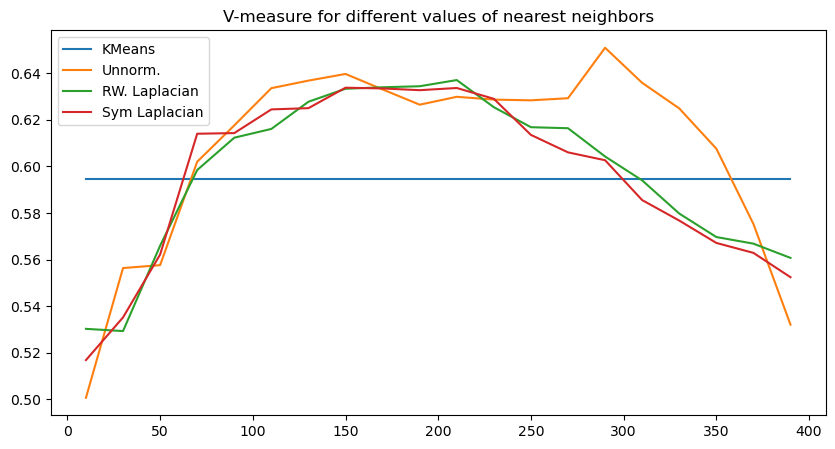

In [12]:
k_neighbor_values = np.arange(10,400,20)

measure_kmeans = []
measure_unnorm = []
measure_rw = []
measure_sym = []

for num_neighbors in k_neighbor_values:
    #print("Number of nearest neighbors k={}".format(num_neighbors))
    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    y_kmeans = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Spectral Clustering
    params = {
        'k_neighbors': num_neighbors
    }
    # Unnormalized 
    unnorm = unnormalizedSpectralClustering(X,n_clusters,params)
    y_unnorm = unnorm['labels']
    # Normalized - Random Walk Laplacian
    norm_rw = normalizedRWSpectralClustering(X,n_clusters,params)
    y_rw = norm_rw['labels']
    # Normalized - Symmetric Laplacian
    norm_sym = normalizedSymSpectralClustering(X,n_clusters,params)
    y_sym = norm_sym['labels']
    
    measure_kmeans.append(v_measure_score(y, y_kmeans))
    measure_unnorm.append(v_measure_score(y, y_unnorm))
    measure_rw.append(v_measure_score(y, y_rw))
    measure_sym.append(v_measure_score(y, y_sym))

plt.figure(figsize=(10,5))
plt.title("V-measure for different values of nearest neighbors")
plt.plot(k_neighbor_values, measure_kmeans, label='KMeans')
plt.plot(k_neighbor_values, measure_unnorm, label='Unnorm.')
plt.plot(k_neighbor_values, measure_rw, label='RW. Laplacian')
plt.plot(k_neighbor_values, measure_sym, label='Sym Laplacian')
plt.legend()